# Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re


#NLTK
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#SKLEARN, Wordcloud...
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2021-09-22 17:59:32.974929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Files 

## Dataset load

In [2]:
dataset = pd.read_csv("/kaggle/input/twitter-sentiment-analysis-and-word-embeddings/Dataset/training_dataset.csv", encoding="latin", header=None)

# Show some examples

In [3]:
dataset.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Setting headers

In [4]:
column_names = ["target","id","date","query","username","content"]
dataset.columns = column_names

## Result 

In [5]:
dataset.head(5)

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Explore data

## Check for missing values

In [6]:
missing_values = dataset.isna().sum()
missing_values

target      0
id          0
date        0
query       0
username    0
content     0
dtype: int64



```
 There are 0 missing values within this dataset
```



## Target distribution 

### Negative samples : *target = 0*

#### Display some examples

In [7]:
negative_samples = dataset[dataset["target"]==0]
negative_samples.head()

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### Show count

In [8]:
negative_samples_count = len(negative_samples)
print(f"Number of negative samples : {negative_samples_count}")

Number of negative samples : 800000


### Neutral samples : *target=2*

#### Display some examples

In [9]:
neutral_samples = dataset[dataset["target"]==2]
neutral_samples.head(5)

,target,id,date,query,username,content


#### Show count

In [10]:
neutral_samples_count = len(neutral_samples)
print(f"Number of neutral samples : {neutral_samples_count}")

Number of neutral samples : 0




```
0 neutral sample ? Wow
```



### Positive samples

#### Display some results 

In [11]:
positive_samples = dataset[dataset["target"]==4]
positive_samples.head(5)

,target,id,date,query,username,content
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


#### Show count

In [12]:
positive_samples_count = len(positive_samples)
print(f"Number of positive samples {positive_samples_count}")

Number of positive samples 800000


## Target distribution plot

#### Defining data

In [13]:
data = [negative_samples_count, neutral_samples_count, positive_samples_count]
labels = ["Negative","Neutral","Positive"]

#### Define color palette

In [14]:
colors = sns.color_palette("pastel")[0:3]

#### Create pie chart

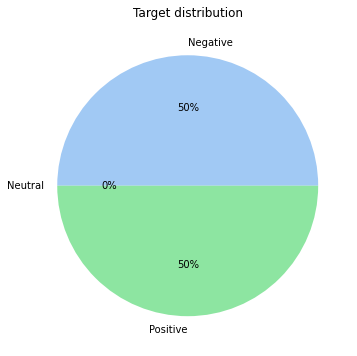

In [15]:
plt.figure(figsize=(6,6))
plt.title("Target distribution")
plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

# Preparing data 

## Drop unncessary columns

In [16]:
dataset.drop(["id","date","query","username"],axis=1, inplace=True)

### Result

In [17]:
dataset.head(5)

,target,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Replace 4 by 1 (TRUE)

In [18]:
dataset.target = dataset.target.replace({4: 1})

### Result

In [19]:
dataset.head(5)

,target,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [20]:
dataset[dataset["target"]==1]

,target,content
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


## Removing mentions, links, extra spaces from tweets

In [21]:
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

### Apply preprocessing

In [22]:
dataset.content = dataset.content.apply(lambda x: re.sub(regex, ' ', str(x).lower()).strip())

### Show results 

In [23]:
dataset.head(10)

,target,content
0,0,awww that s a bummer you shoulda got david car...
1,0,is upset that he can t update his facebook by ...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i h...
5,0,not the whole crew
6,0,need a hug
7,0,hey long time no see yes rains a bit only a bi...
8,0,nope they didn t have it
9,0,que me muera


## Train/test split

In [24]:
train, test = train_test_split(dataset, test_size=0.1, random_state=44)



```
The dataset is large enough to proceed to a 90-10 split. 
```



### Display results 

In [25]:
print(f"Training set length: {len(train)/1e6}M examples")
print(f"Test set length: {len(test)/1e6}M examples")

Training set length: 1.44M examples
Test set length: 0.16M examples


## Tokenization

### Define the tokenizer

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.content)
vocab_size = len(tokenizer.word_index)+1

In [27]:
print(f"Word index length: {len(tokenizer.word_index)}")
print(f"Some words: {list(tokenizer.word_index.keys())[0:10]}")

Word index length: 313592
Some words: ['i', 'to', 'the', 'a', 'my', 'it', 'and', 'you', 'is', 'in']


### Get the max length

In [28]:
content = dataset["content"]

In [29]:
max_length = len(content[0].split())
for tweet in content: 
  length = len(tweet.split())
  if length > max_length: 
    max_length = length

print(f"Maximum token length: {max_length}")

Maximum token length: 53


### Define sequences

In [30]:
sequences_train = tokenizer.texts_to_sequences(train.content)
sequences_test = tokenizer.texts_to_sequences(test.content)

### Define X_train, X_test, y_train, y_test, 

In [31]:
X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.target.values
y_test = test.target.values

print(X_train.shape)

(1440000, 53)


## Word Embeddings (GloVe)

### Setup

In [32]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open("/kaggle/input/twitter-sentiment-analysis-and-word-embeddings/Dataset/word_embeddings.txt")

### Apply word embedding

In [33]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

# Define the model

## Set training parameters

In [34]:
num_epochs = 50
batch_size = 1000

## Create the model

### Define the embedding layer

In [35]:
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

### Define early stopping as the model callback

In [36]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode ="max", verbose=2, restore_best_weights=True)

### Create the model

In [37]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

2021-09-22 18:01:35.041991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-22 18:01:35.045688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-22 18:01:35.101185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 18:01:35.101841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-22 18:01:35.101972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-22 18:01:35.127643: I tensorflow/stream_executor/platform/def

## Compile the model

In [38]:
model.compile(
       optimizer = Adam(learning_rate = 0.001 ),
       loss="binary_crossentropy", 
       metrics=["accuracy"]
  )

## Model summary 

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 100)           31359300  
_________________________________________________________________
bidirectional (Bidirectional (None, 53, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 53, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 53, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

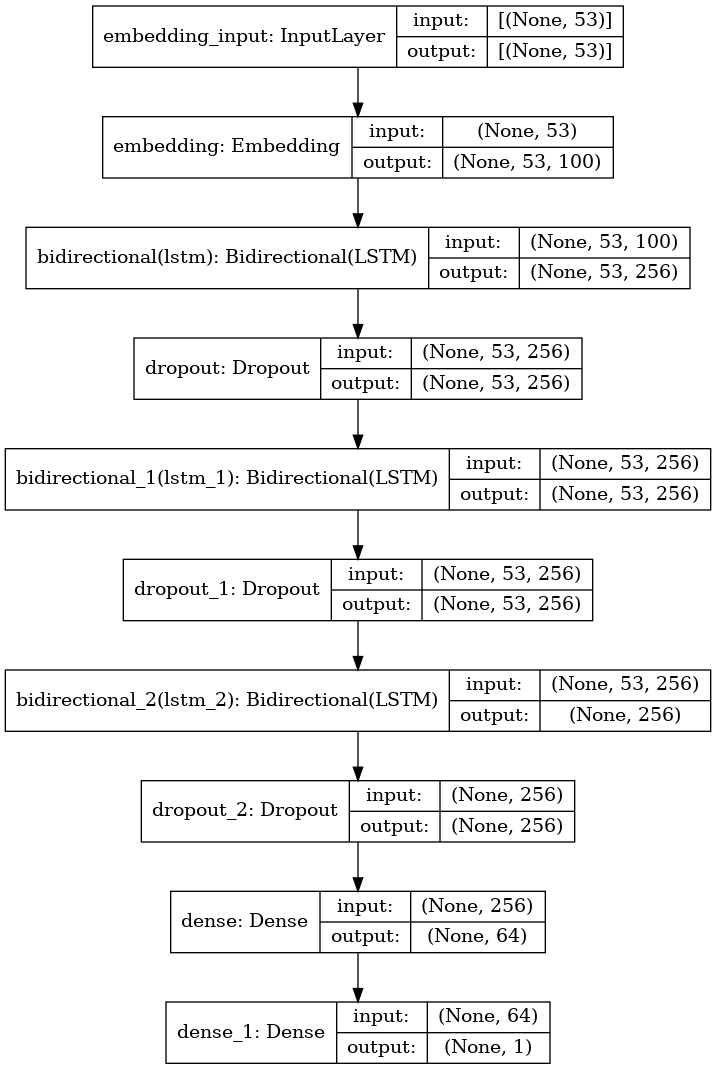

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Train the model

In [41]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1, 
    validation_data=(X_test,y_test),
    callbacks = [stop_early]
)

2021-09-22 18:01:41.513653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-22 18:01:41.523970: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


Epoch 1/50


2021-09-22 18:01:46.922204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-22 18:01:47.837451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-22 18:01:47.901810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1440/1440 [==============================] - 173s 112ms/step - loss: 0.5131 - accuracy: 0.7417 - val_loss: 0.4340 - val_accuracy: 0.7995
Epoch 2/50
1440/1440 [==============================] - 160s 111ms/step - loss: 0.4264 - accuracy: 0.8028 - val_loss: 0.4083 - val_accuracy: 0.8117
Epoch 3/50
1440/1440 [==============================] - 160s 111ms/step - loss: 0.4039 - accuracy: 0.8153 - val_loss: 0.3987 - val_accuracy: 0.8191
Epoch 4/50
1440/1440 [==============================] - 159s 111ms/step - loss: 0.3884 - accuracy: 0.8237 - val_loss: 0.4032 - val_accuracy: 0.8156
Epoch 5/50
1440/1440 [==============================] - 159s 111ms/step - loss: 0.3771 - accuracy: 0.8302 - val_loss: 0.3849 - val_accuracy: 0.8257
Epoch 6/50
1440/1440 [==============================] - 159s 111ms/step - loss: 0.3671 - accuracy: 0.8352 - val_loss: 0.3802 - val_accuracy: 0.8285
Epoch 7/50
1440/1440 [==============================] - 159s 111ms/step - loss: 0.3580 - accuracy: 0.8403 - val_loss: 0.384

# Save the model

 ## Define text vectorization 

In [42]:
vocabulary = list(tokenizer.word_index.keys())

In [43]:
input_shape = tf.keras.Input(shape=(max_length))
shape = input_shape.shape
shape

TensorShape([None, 53])

In [44]:
vectorize_layer = TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=vocab_size+1,
    output_mode='int',
    output_sequence_length=max_length, 
    vocabulary=vocabulary
)
vectorize_layer.adapt(train["content"].values)

## Define the export model

In [45]:
export_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
    vectorize_layer,
    model,
    Activation('sigmoid')
])

## Compile

In [46]:
export_model.compile(
       optimizer = Adam(learning_rate = 0.001 ),
       loss="binary_crossentropy", 
       metrics=["accuracy"]
)

## Save

In [47]:
export_model.save("TSA_model_v3")

2021-09-22 18:55:48.330229: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Plot the results

In [48]:
number_of_epochs = len(history.history["loss"])
print(f"Number of epochs: {number_of_epochs}")

Number of epochs: 19


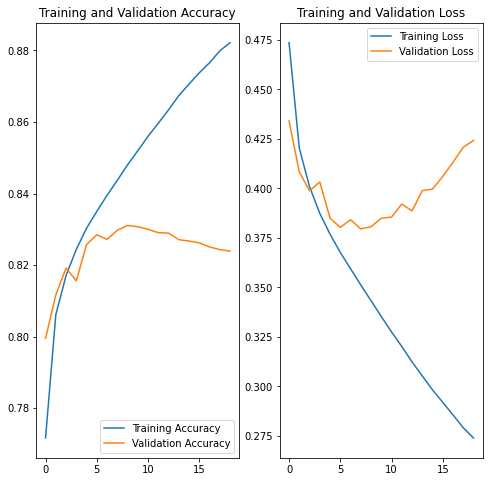

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(number_of_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
best_accuracy = max(history.history["val_accuracy"])
print(f"Best validation accuracy : {best_accuracy}")

Best validation accuracy : 0.8310812711715698


## Print f1-score, precision and recall

In [51]:
predictions = model.predict(X_test)
predictions = np.where(predictions<0.5, 0, 1)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     79800
           1       0.82      0.85      0.83     80200

    accuracy                           0.83    160000
   macro avg       0.83      0.83      0.83    160000
weighted avg       0.83      0.83      0.83    160000



## Test

In [52]:
examples = ["being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup"]

print("Examples: ", examples, " Type: ", type(examples))

export_model.predict(examples)

Examples:  ['being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup']  Type:  <class 'list'>


array([[0.6540012]], dtype=float32)

# Tune the threshold (experimental)

In [53]:
predictions = model.predict(X_test)

# Calculate the best f1 score for each threshold

In [54]:
thresholds = np.arange(0, 1, 0.001)
thres = 0.1
f1_score = 0.001

## Positive

In [55]:
for threshold in thresholds :
    prediction = np.where(predictions>threshold, 1, 0)
    report = classification_report(y_test, prediction, output_dict=True)
    f1_score_new = report["1"]["f1-score"]
    if f1_score_new > f1_score: 
        f1_score = f1_score_new
        thres = threshold
                      
print(f"Best threshold : {thres} \nBest f1_score: {f1_score}")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best threshold : 0.451 
Best f1_score: 0.8351197263397947


## Negative

In [56]:
thres_neg = 0.1
f1_score_neg = 0.001
for threshold in thresholds :
    prediction = np.where(predictions>threshold, 1, 0)
    report = classification_report(y_test, prediction, output_dict=True)
    f1_score_new = report["0"]["f1-score"]
    if f1_score_new > f1_score_neg: 
        f1_score_neg = f1_score_new
        thres_neg = threshold
                      
print(f"Best threshold : {thres_neg} \nBest f1_score: {f1_score_neg}")

Best threshold : 0.644 
Best f1_score: 0.834760187501114


In [57]:
examples = [ "this is a very good day, don't you think so ?" ]

print("Examples: ", examples, " Type: ", type(examples))

export_model.predict(examples)

Examples:  ["this is a very good day, don't you think so ?"]  Type:  <class 'list'>


array([[0.72540784]], dtype=float32)